In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
import pandas as pd

In [3]:
image_path = "/content/image.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
image.shape

(480, 640, 3)

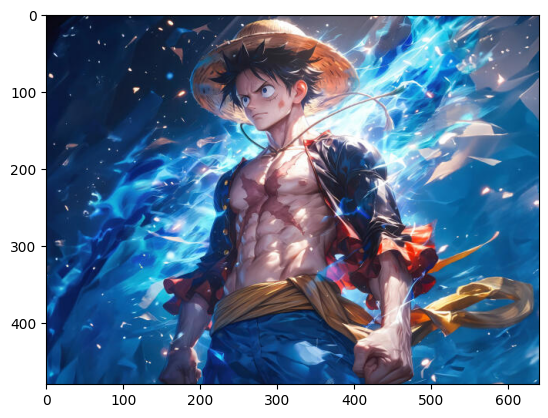

In [ ]:
plt.imshow(image)

In [4]:
image = cv2.resize(image,(300,300))

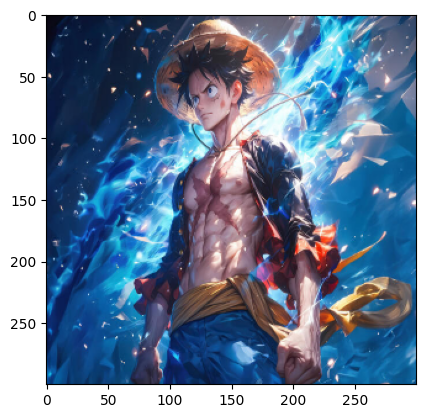

In [ ]:
plt.imshow(image)

In [ ]:
def mask_image(img, prop):
    img = torch.from_numpy(img).float()
    img_copy = img.clone()
    mask = torch.rand(img.shape) < prop
    img_copy[mask] = float('nan')
    return img_copy

In [ ]:
R = image[:,:,0]
G = image[:,:,1]
B = image[:,:,2]

In [ ]:
masked_R = mask_image(R, 0.2)
masked_G = mask_image(G, 0.2)
masked_B = mask_image(B, 0.2)

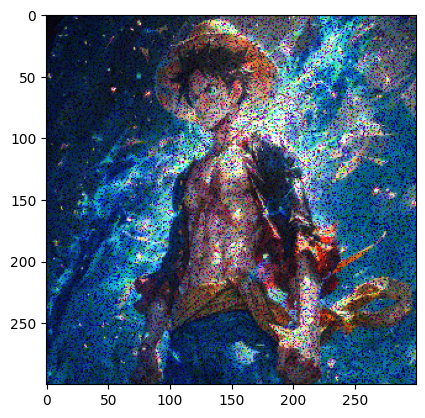

In [ ]:
plt.imshow(np.clip(np.stack([masked_R,masked_G,masked_B], axis=2),0,255).astype(np.uint8))

In [ ]:
def factorize(A, k, device=torch.device("cpu")):
    """Factorize the matrix D into A and B"""
    A = A.to(device)
    # Randomly initialize A and B
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    # Optimizer
    optimizer = torch.optim.Adam([W, H], lr=0.01)
    mask = ~torch.isnan(A)
    # Train the model
    for i in range(10000):
        # Compute the loss
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)

        # Zero the gradients
        optimizer.zero_grad()

        # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()

    return W, H, loss

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
W_r, H_r, loss_r = factorize(masked_R, 175, device=device)
W_g, H_g, loss_g = factorize(masked_G, 175, device=device)
W_b, H_b, loss_b = factorize(masked_B, 175, device=device)

In [ ]:
loss = loss_r + loss_g + loss_b
loss

tensor(71.8153, device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
reconstructed_image = np.clip(np.stack([(W_r@H_r).cpu().detach().numpy(),(W_g@H_g).cpu().detach().numpy(),(W_b@H_b).cpu().detach().numpy()],axis =2), 0, 255).astype(np.uint8)

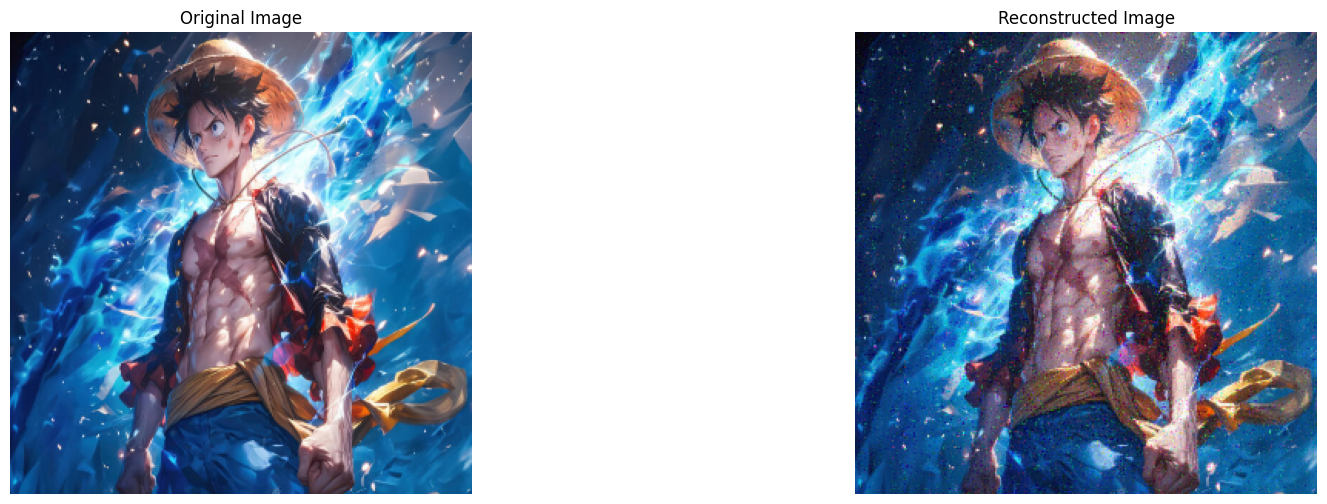

In [ ]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.imshow(image,cmap = "gray")
plt.title("Original Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image)
plt.title(f"Reconstructed Image")
rmse = torch.sqrt(loss).mean()
psnr = 10 * torch.log10(255.0 / loss.mean())
plt.axis("off")
plt.show()

In [ ]:
rmse = torch.sqrt(loss).mean()
psnr = 10 * torch.log10(255.0 / loss.mean())

In [ ]:
print(f" RMSE = {rmse.cpu().detach().numpy()}, PSNR = {psnr.cpu().detach().numpy()}")

 RMSE = 8.474388122558594, PSNR = 5.503234386444092


### Part 2

In [7]:
x, y = (100,100)
patch_size = 30
patch = image[y:y+patch_size, x:x+patch_size,2]

In [8]:
img = torch.from_numpy(image).float()
img[y:y+patch_size, x:x+patch_size] = float("nan")

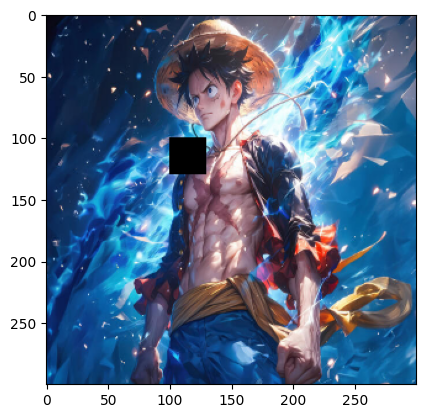

In [ ]:
plt.imshow(np.clip(img.cpu().detach().numpy(),0,255).astype(np.uint8))

In [ ]:
R = img[:,:,0]
G = img[:,:,1]
B = img[:,:,2]

In [ ]:
def factorize_less(A, k, device=torch.device("cpu")):
    """Factorize the matrix D into A and B"""
    A = A.to(device)
    # Randomly initialize A and B
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    # Optimizer
    optimizer = torch.optim.Adam([W, H], lr=0.01)
    mask = ~torch.isnan(A)
    # Train the model
    for i in range(1000):
        # Compute the loss
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)

        # Zero the gradients
        optimizer.zero_grad()

        # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()

    return W, H, loss

In [ ]:
W_r, H_r, loss_r = factorize_less(R, 200, device=device)
W_g, H_g, loss_g = factorize_less(G, 200, device=device)
W_b, H_b, loss_b = factorize_less(B, 200, device=device)

In [ ]:
loss = loss_r + loss_g + loss_b
loss

tensor(1225.6421, device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
reconstructed_image = np.clip(np.stack([(W_r@H_r).cpu().detach().numpy(),(W_g@H_g).cpu().detach().numpy(),(W_b@H_b).cpu().detach().numpy()],axis =2), 0, 255).astype(np.uint8)

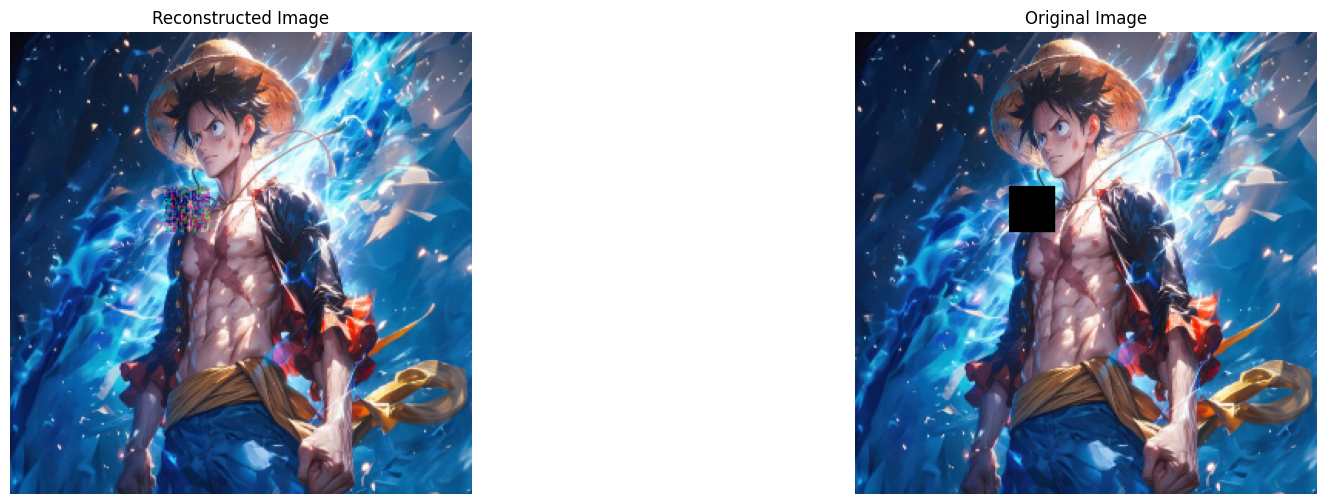

In [ ]:
plt.figure(figsize=(20, 6))
plt.subplot(1,2,1)
plt.imshow(reconstructed_image)
plt.title("Reconstructed Image")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(np.clip(img.cpu().detach().numpy(),0,255).astype(np.uint8))
plt.title("Original Image")
plt.axis('off')
plt.show()

In [ ]:
rmse = torch.sqrt(loss).mean()
psnr = 10 * torch.log10(255.0 / loss.mean())
print(f" RMSE = {rmse.cpu().detach().numpy()}, PSNR = {psnr.cpu().detach().numpy()}")

 RMSE = 35.00917053222656, PSNR = -6.818234920501709


**Using RFF and Linear Regression**

In [5]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import Ridge

In [17]:
import numpy as np
import torch
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import Ridge

def reconstruct_channel(img_channel, gamma=10.0, n_components=40000, alpha=1.0):
    """Reconstructs a single channel (R, G, or B) using Random Fourier Features and Ridge Regression."""
    # Convert the channel to NumPy if it's a PyTorch tensor
    img_np = img_channel.cpu().numpy() if isinstance(img_channel, torch.Tensor) else img_channel

    # 1. Generate pixel coordinates (x, y)
    height, width = img_np.shape
    x_coords, y_coords = np.meshgrid(np.arange(width), np.arange(height))
    coordinates = np.stack([x_coords.ravel(), y_coords.ravel()], axis=-1)

    # 2. Mask the known and missing pixels
    mask_known = ~np.isnan(img_np)  # True where pixel is known
    mask_missing = np.isnan(img_np)  # True where pixel is NaN

    # Get the known pixel coordinates and their corresponding values
    known_coords = coordinates[mask_known.ravel()]  # Known pixel coordinates
    known_values = img_np[mask_known]               # Known pixel values

    # 3. Generate Random Fourier Features to approximate RBF kernel
    rbf_feature = RBFSampler(gamma=gamma, n_components=n_components, random_state=42)

    # Transform the known pixel coordinates into RFF space
    X_features_known = rbf_feature.fit_transform(known_coords)

    # 4. Train Ridge Regression on the known pixel values
    ridge_regressor = Ridge(alpha=alpha)
    ridge_regressor.fit(X_features_known, known_values)

    # 5. Predict missing pixel values
    missing_coords = coordinates[mask_missing.ravel()]  # Missing pixel coordinates
    X_features_missing = rbf_feature.transform(missing_coords)  # RFF for missing pixels
    predicted_values = ridge_regressor.predict(X_features_missing)  # Predicted missing values

    # 6. Reconstruct the original channel by filling in the missing values
    reconstructed_channel = np.copy(img_np)
    reconstructed_channel[mask_missing] = predicted_values

    return reconstructed_channel

# Assuming img is a PyTorch tensor of shape (height, width, 3)
# Split the image into R, G, and B channels
r_channel = img[:, :, 0]
g_channel = img[:, :, 1]
b_channel = img[:, :, 2]

# Reconstruct each channel using the reconstruct_channel function
r_reconstructed = reconstruct_channel(r_channel)
g_reconstructed = reconstruct_channel(g_channel)
b_reconstructed = reconstruct_channel(b_channel)

# Stack the reconstructed channels to form the final RGB image
reconstructed_image = np.stack((r_reconstructed, g_reconstructed, b_reconstructed), axis=2)
reconstructed_image = np.clip(reconstructed_image, 0, 255).astype(np.uint8)

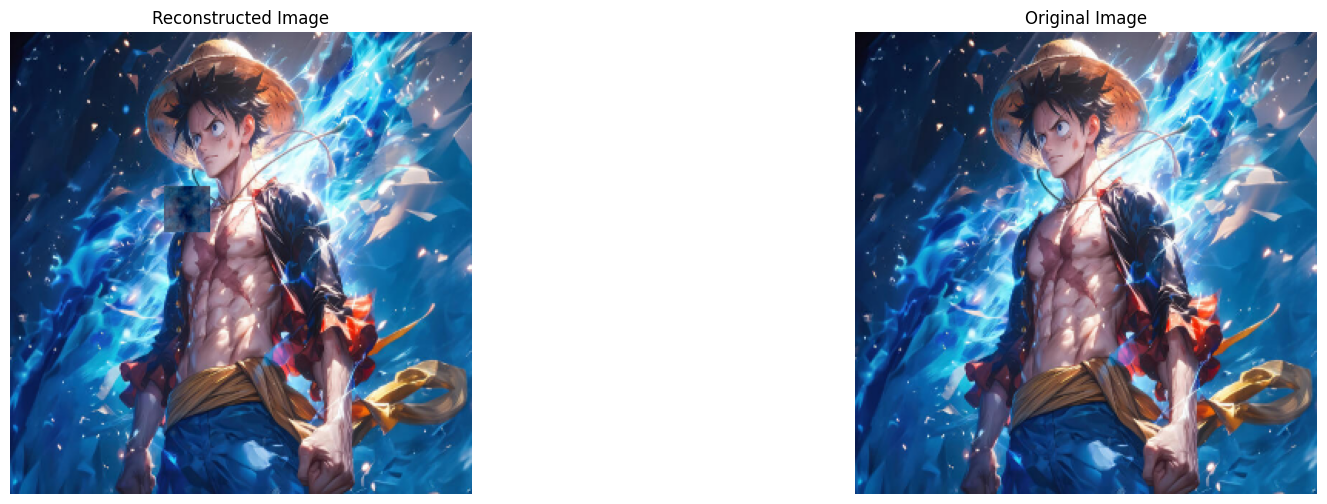

In [18]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.imshow(reconstructed_image)
plt.title("Reconstructed Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')
plt.show()

In [19]:
import cv2
import numpy as np

def calculate_rmse(image1, image2):
    # Compute the RMSE
    mse = np.mean((image1 - image2) ** 2)
    rmse = np.sqrt(mse)
    return rmse

def calculate_psnr(image1, image2):
    # Compute RMSE
    rmse = calculate_rmse(image1, image2)
    if rmse == 0:
        return float('inf')  # No noise

    # Compute PSNR
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / rmse)
    return psnr

# Load images
image1 = reconstructed_image.astype(np.float32)
image2 = image.astype(np.float32)

# Calculate RMSE and PSNR
rmse = calculate_rmse(image1, image2)
psnr = calculate_psnr(image1, image2)

print(f"RMSE: {rmse}")
print(f"PSNR: {psnr}")


RMSE: 11.167415618896484
PSNR: 27.171750016222145
